In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from pycaret.time_series import *
import numpy as np
import os
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [32]:
df = pd.read_csv(r'D:\pycaret_entorno\ventas_organizadas_tanques.csv')

In [33]:
# Convertir la columna 'Fecha' a formato datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%Y-%m-%d')

# Verificar las primeras filas
df.head()

,Fecha,KIT JUEGO TANQUE 1000 L,KIT JUEGO TANQUE 2000 L,KIT JUEGO TANQUE 250 L,KIT JUEGO TANQUE 500 L
0,2019-01-08,29.0,0.0,0.0,1.0
1,2019-01-09,27.0,18.0,4.0,14.0
2,2019-01-10,0.0,7.0,0.0,0.0
3,2019-01-11,10.0,0.0,25.0,8.0
4,2019-01-14,15.0,1.0,0.0,9.0


In [34]:
# Crear un rango completo de fechas diarias
fecha_min = df['Fecha'].min()
fecha_max = df['Fecha'].max()
rango_fechas_diario = pd.date_range(start=fecha_min, end=fecha_max, freq='D')

# Crear un DataFrame base con este rango de fechas
df_completo = pd.DataFrame({'Fecha': rango_fechas_diario})


In [35]:
# Inicializar el DataFrame completo con las fechas
productos = ['KIT JUEGO TANQUE 1000 L', 'KIT JUEGO TANQUE 2000 L', 'KIT JUEGO TANQUE 250 L', 'KIT JUEGO TANQUE 500 L']

for producto in productos:
    # Seleccionar las ventas del producto con la columna Fecha
    producto_ventas = df[['Fecha', producto]]

    # Hacer merge con el rango completo de fechas
    producto_completo = df_completo.merge(producto_ventas, on='Fecha', how='left')

    # Rellenar los valores faltantes con 0
    producto_completo[producto] = producto_completo[producto].fillna(0)

    # Agregar la columna al DataFrame final
    df_completo[producto] = producto_completo[producto]



In [36]:
df_completo.head()

,Fecha,KIT JUEGO TANQUE 1000 L,KIT JUEGO TANQUE 2000 L,KIT JUEGO TANQUE 250 L,KIT JUEGO TANQUE 500 L
0,2019-01-08,29.0,0.0,0.0,1.0
1,2019-01-09,27.0,18.0,4.0,14.0
2,2019-01-10,0.0,7.0,0.0,0.0
3,2019-01-11,10.0,0.0,25.0,8.0
4,2019-01-12,0.0,0.0,0.0,0.0


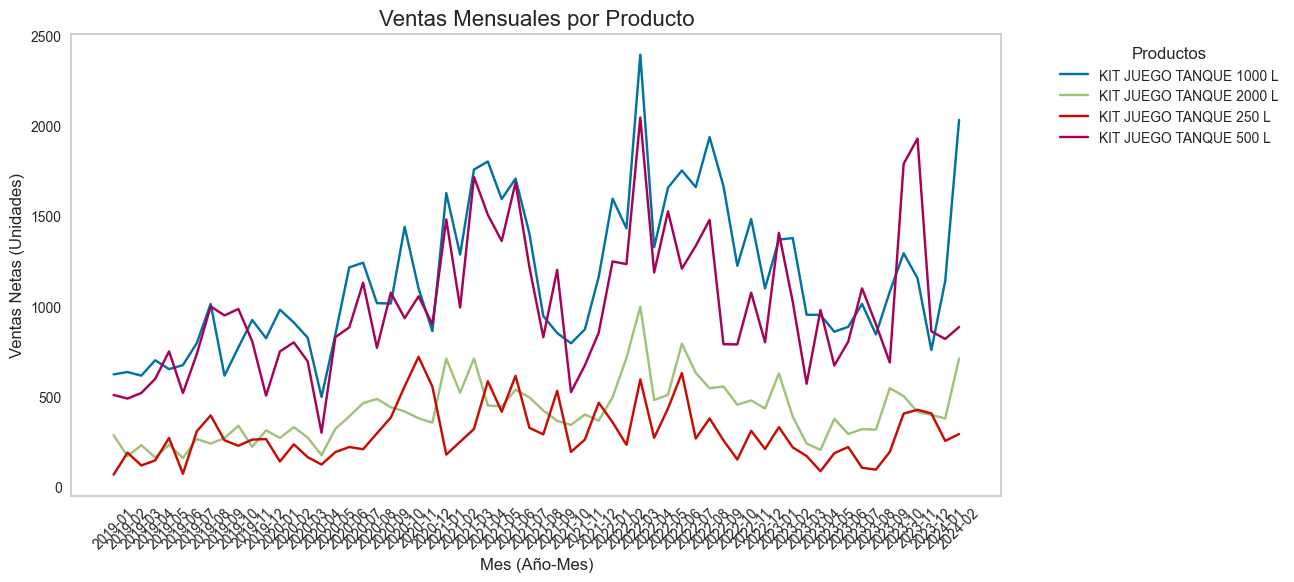

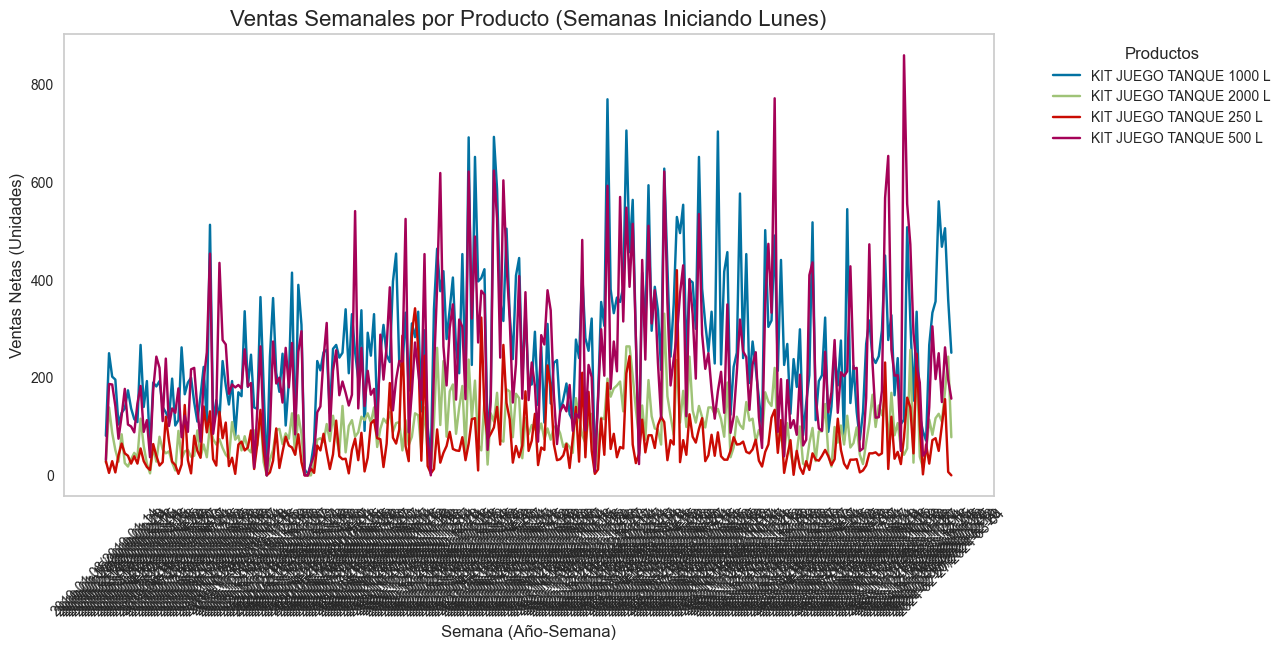

In [37]:

# Asegurar que 'Fecha' sea de tipo datetime
df_completo['Fecha'] = pd.to_datetime(df_completo['Fecha'], format='%Y-%m-%d')

# Crear una nueva columna con el mes (Año-Mes) en formato de texto para agrupar
df_completo['Mes'] = df_completo['Fecha'].dt.to_period('M')

# Agrupar por mes y sumar las ventas de cada producto
ventas_mensuales = df_completo.groupby('Mes').sum(numeric_only=True)

# Crear una nueva columna con la semana (Año-Semana) ajustada para que empiece el lunes
df_completo['Semana'] = df_completo['Fecha'].dt.to_period('W-MON')

# Agrupar por semana con el ajuste y sumar las ventas de cada producto
ventas_semanales = df_completo.groupby('Semana').sum(numeric_only=True)

# Convertir los índices de periodos a strings para las gráficas
ventas_mensuales.index = ventas_mensuales.index.astype(str)
ventas_semanales.index = ventas_semanales.index.astype(str)

# Graficar los datos mensuales
plt.figure(figsize=(12, 6))
for producto in ventas_mensuales.columns:
    plt.plot(ventas_mensuales.index, ventas_mensuales[producto], label=producto)
plt.title("Ventas Mensuales por Producto", fontsize=16)
plt.xlabel("Mes (Año-Mes)", fontsize=12)
plt.ylabel("Ventas Netas (Unidades)", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Productos", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

# Graficar los datos semanales ajustados
plt.figure(figsize=(12, 6))
for producto in ventas_semanales.columns:
    plt.plot(ventas_semanales.index, ventas_semanales[producto], label=producto)
plt.title("Ventas Semanales por Producto (Semanas Iniciando Lunes)", fontsize=16)
plt.xlabel("Semana (Año-Semana)", fontsize=12)
plt.ylabel("Ventas Netas (Unidades)", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Productos", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()


In [38]:
# Asegurarse de que la columna Fecha sea de tipo datetime
df_completo['Fecha'] = pd.to_datetime(df_completo['Fecha'], errors='coerce')

# Crear una columna adicional para identificar semanas que comienzan el lunes
df_completo['Semana'] = df_completo['Fecha'].dt.to_period('W-MON')

# Agrupar por semanas y sumar las ventas
df_semanal = df_completo.groupby('Semana').sum(numeric_only=True).reset_index()

In [39]:
df_semanal.head()

,Semana,KIT JUEGO TANQUE 1000 L,KIT JUEGO TANQUE 2000 L,KIT JUEGO TANQUE 250 L,KIT JUEGO TANQUE 500 L
0,2019-01-08/2019-01-14,81.0,26.0,29.0,32.0
1,2019-01-15/2019-01-21,250.0,139.0,5.0,187.0
2,2019-01-22/2019-01-28,202.0,87.0,29.0,186.0
3,2019-01-29/2019-02-04,196.0,52.0,6.0,142.0
4,2019-02-05/2019-02-11,104.0,28.0,41.0,75.0


Entra en el código

In [40]:
def split_train_test(data, test_size=8):
    """
    Divide los datos en conjuntos de entrenamiento y prueba.
    Los últimos `test_size` periodos se asignan al conjunto de prueba.

    Parámetros:
    - data (pd.Series): Serie de pandas con un índice tipo fecha.
    - test_size (int): Número de periodos para el conjunto de prueba (por defecto, 4).

    Retorna:
    - train_data (pd.Series): Conjunto de entrenamiento.
    - test_data (pd.Series): Conjunto de prueba.
    """
    # Ordenar los datos por índice
    data = data.sort_index()

    # Dividir los datos
    train_data = data.iloc[:-test_size].copy()  # Todo excepto los últimos `test_size` periodos
    test_data = data.iloc[-test_size:].copy()  # Últimos `test_size` periodos

    return train_data, test_data


In [41]:
# Crear series temporales independientes para cada producto
productos = ['KIT JUEGO TANQUE 1000 L', 'KIT JUEGO TANQUE 2000 L', 'KIT JUEGO TANQUE 250 L', 'KIT JUEGO TANQUE 500 L']

# Crear un diccionario con las series temporales de cada producto
series_dict = {producto: df_semanal[['Semana', producto]].set_index('Semana')[producto] for producto in productos}

# Dividir cada serie en conjuntos de entrenamiento y prueba
train_test_dict = {
    producto: split_train_test(serie, test_size=8)  # Últimos 4 periodos como conjunto de prueba
    for producto, serie in series_dict.items()
}

# Verificar las divisiones
for producto, (train_data, test_data) in train_test_dict.items():
    print(f"\nProducto: {producto}")
    print(f"  Tamaño de entrenamiento: {len(train_data)}")
    print(f"  Tamaño de prueba: {len(test_data)}")


Producto: KIT JUEGO TANQUE 1000 L
  Tamaño de entrenamiento: 261
  Tamaño de prueba: 8

Producto: KIT JUEGO TANQUE 2000 L
  Tamaño de entrenamiento: 261
  Tamaño de prueba: 8

Producto: KIT JUEGO TANQUE 250 L
  Tamaño de entrenamiento: 261
  Tamaño de prueba: 8

Producto: KIT JUEGO TANQUE 500 L
  Tamaño de entrenamiento: 261
  Tamaño de prueba: 8


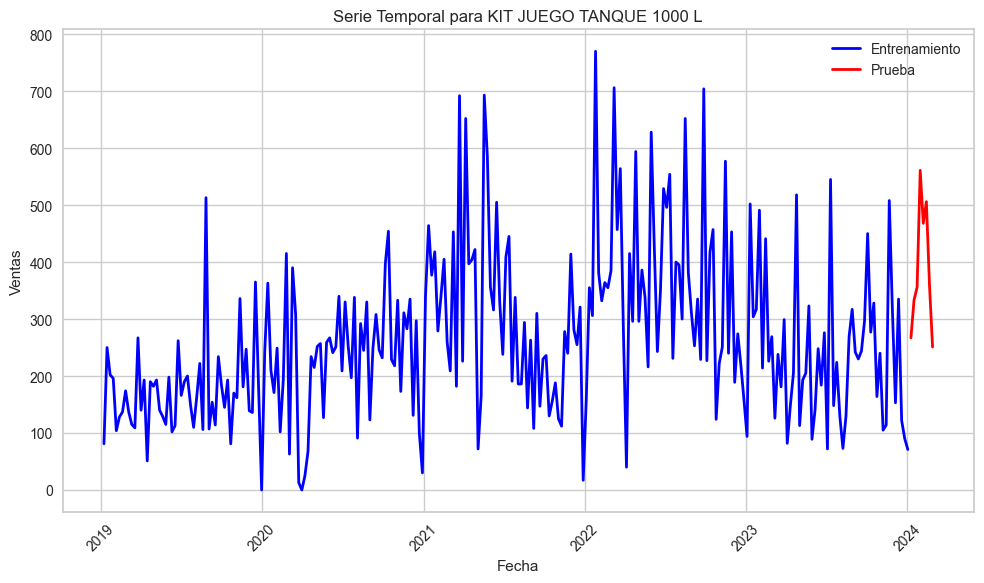

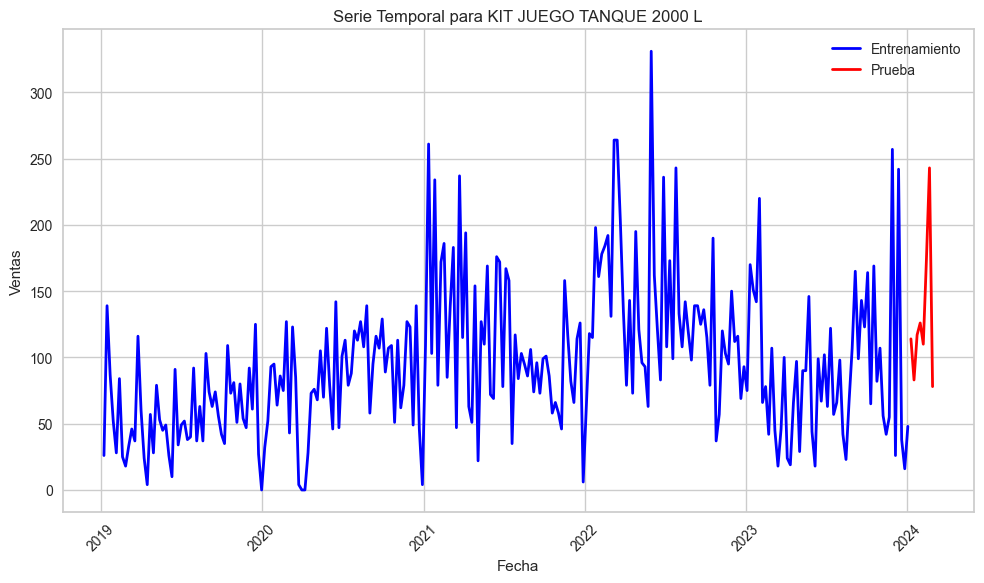

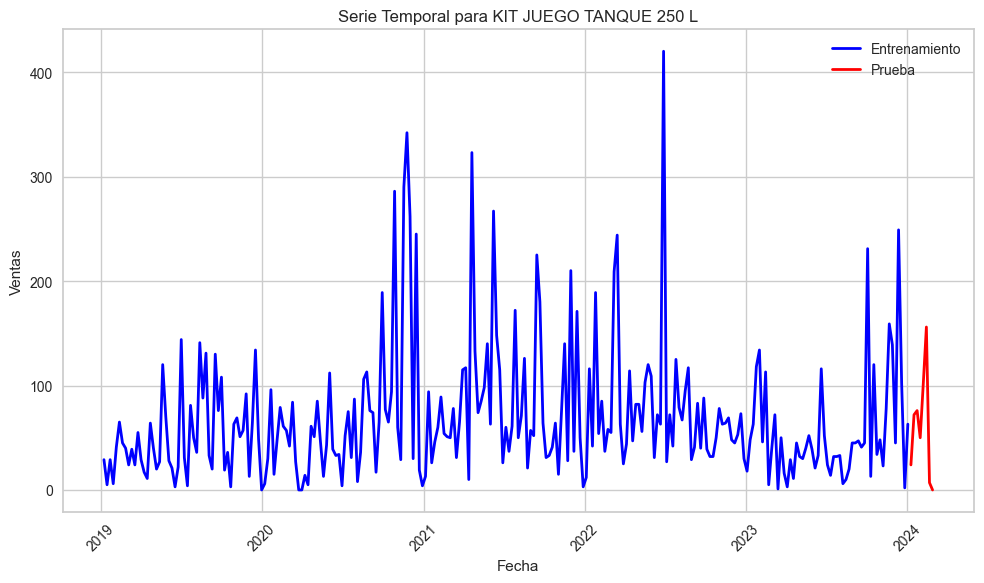

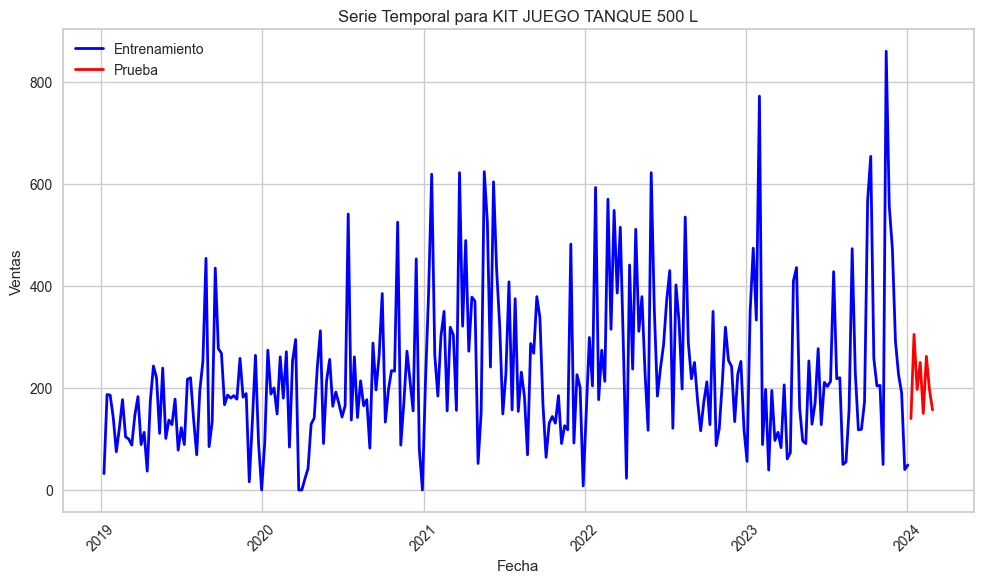

In [42]:
# Definir los colores para los diferentes conjuntos
colors = {'train': 'blue', 'test': 'red'}

# Crear los gráficos para cada producto
for producto, (train_data, test_data) in train_test_dict.items():
    # Convertir los índices a formato datetime si es necesario
    train_data.index = train_data.index.to_timestamp()  # Convierte PeriodIndex a Timestamp
    test_data.index = test_data.index.to_timestamp()

    # Crear la figura
    plt.figure(figsize=(10, 6))

    # Graficar conjunto de entrenamiento
    plt.plot(train_data.index, train_data, label='Entrenamiento', color=colors['train'], linewidth=2)

    # Graficar conjunto de prueba
    plt.plot(test_data.index, test_data, label='Prueba', color=colors['test'], linewidth=2)

    # Agregar título y etiquetas
    plt.title(f'Serie Temporal para {producto}')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas')

    # Añadir leyenda
    plt.legend()

    # Mostrar gráfico
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
def entrenar_guardar_predecir(train_data, nombre_producto, fh=4, save_dir="models", results_dir="results"):
    """
    Entrena un modelo de series temporales, guarda el mejor modelo y genera predicciones, y guarda las predicciones.

    Args:
        train_data (pd.Series): Datos de entrenamiento.
        nombre_producto (str): Nombre del producto.
        fh (int): Horizonte de predicción. Por defecto, 4.
        save_dir (str): Directorio donde se guardará el modelo. Por defecto, 'models'.
        results_dir (str): Directorio donde se guardarán las predicciones. Por defecto, 'results'.

    Returns:
        dict: Contiene el mejor modelo, la ruta del modelo guardado y las predicciones.
    """
    available_models = ["naive", "grand_means", "polytrend", "auto_arima", "exp_smooth", "ets",
                        "theta", "croston", "bats", "tbats", "prophet", "lr_cds_dt", "en_cds_dt",
                        "ridge_cds_dt", "lasso_cds_dt", "llar_cds_dt", "br_cds_dt", "huber_cds_dt",
                        "omp_cds_dt", "knn_cds_dt", "dt_cds_dt", "rf_cds_dt", "et_cds_dt", "gbr_cds_dt",
                        "ada_cds_dt", "xgboost_cds_dt", "lightgbm_cds_dt"]
    # Crear una ruta hacia la carpeta "models" dentro del proyecto actual
    save_dir = os.path.join(os.getcwd(), save_dir)  # Ruta absoluta a "models"
    os.makedirs(save_dir, exist_ok=True)  # Crear carpeta si no existe

    # Crear y configurar el experimento de PyCaret
    exp = TSForecastingExperiment()
    exp.setup(data=train_data, seasonal_period=8, session_id=123, fold=4, fh=fh, numeric_imputation_target="mean")

    # Entrenar y seleccionar el mejor modelo
    best_model = exp.compare_models(include = available_models, sort = 'RMSE')

    # Guardar el modelo en formato .pkl dentro de la carpeta "models"
    model_filename = f"{nombre_producto.replace(' ', '_')}_best_model.pkl"
    model_path = os.path.join(save_dir, model_filename)
    joblib.dump(best_model, model_path)
    print(f"Modelo guardado en: {model_path}")

    # Generar predicciones para los próximos `fh` periodos
    forecast = exp.predict_model(best_model, fh=fh)

    # Alinear las predicciones con el índice extendido si es necesario
    last_date = train_data.index[-1]  # Última fecha en el conjunto de entrenamiento
    freq = pd.infer_freq(train_data.index)  # Frecuencia temporal
    forecast_index = pd.date_range(start=last_date, periods=fh + 1, freq=freq)[1:]  # Índice extendido
    forecast.index = forecast_index

    # Crear una carpeta para guardar los resultados si no existe
    results_dir = os.path.join(os.getcwd(), results_dir)  # Ruta absoluta a "results"
    os.makedirs(results_dir, exist_ok=True)  # Crear carpeta si no existe

    # Guardar las predicciones en un archivo CSV
    forecast_filename_csv = os.path.join(results_dir, f"{nombre_producto.replace(' ', '_')}_forecast.csv")
    forecast.to_csv(forecast_filename_csv)



    print(f"Predicciones guardadas como CSV: {forecast_filename_csv}")

    return {"best_model": best_model, "model_path": model_path, "forecast": forecast}

In [44]:
resultados_productos = {}

# Iterar sobre cada producto y su conjunto de datos
for producto, (train_data, _) in train_test_dict.items():  # Extraer solo train_data de la tupla
    print(f"Procesando {producto}...")

    # Entrenar, guardar y predecir
    resultados = entrenar_guardar_predecir(
        train_data=train_data,  # Usar solo el conjunto de entrenamiento
        nombre_producto=producto,
        fh=4  # Horizonte de predicción
    )

    # Guardar resultados para cada producto
    resultados_productos[producto] = resultados

# Mostrar resultados para todos los productos
for producto, resultados in resultados_productos.items():
    print(f"\nProducto: {producto}")
    print(f"Modelo guardado en: {resultados['model_path']}")
    print(f"Predicciones generadas:\n{resultados['forecast']}")



Procesando KIT JUEGO TANQUE 1000 L...


,Description,Value
0,session_id,123
1,Target,KIT JUEGO TANQUE 1000 L
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(261, 1)"
5,Transformed data shape,"(261, 1)"
6,Transformed train set shape,"(257, 1)"
7,Transformed test set shape,"(4, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
prophet,Prophet,0.5888,0.5659,80.2852,98.3122,0.4174,0.3228,0.1437,0.0967
grand_means,Grand Means Forecaster,0.7081,0.6743,96.5588,117.1588,0.4811,0.3794,-0.2983,0.0200
croston,Croston,0.7741,0.7265,105.5534,126.1983,0.4787,0.4171,-0.5967,0.0200
theta,Theta Forecaster,0.7779,0.7293,106.0756,126.7049,0.4889,0.4183,-0.6074,0.0233
bats,BATS,0.7815,0.7320,106.5609,127.1653,0.4848,0.4210,-0.6262,0.8367
tbats,TBATS,0.7815,0.7320,106.5609,127.1653,0.4848,0.4210,-0.6262,1.4033
auto_arima,Auto ARIMA,0.7967,0.7504,108.6335,130.3508,0.4908,0.4307,-0.7546,2.6500
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.8058,0.7537,109.9119,130.9849,0.6375,0.4151,-0.7093,0.0500
ets,ETS,0.7936,0.7613,108.2011,132.2411,0.4919,0.4246,-0.7511,0.0500
polytrend,Polynomial Trend Forecaster,0.8610,0.7703,117.4607,133.8997,0.6821,0.4354,-0.8629,0.0200


Modelo guardado en: d:\pycaret_entorno\models\KIT_JUEGO_TANQUE_1000_L_best_model.pkl


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Prophet,0.6296,0.5246,85.8167,90.8354,0.7935,0.5427,0.2628


Predicciones guardadas como CSV: d:\pycaret_entorno\results\KIT_JUEGO_TANQUE_1000_L_forecast.csv
Procesando KIT JUEGO TANQUE 2000 L...


,Description,Value
0,session_id,123
1,Target,KIT JUEGO TANQUE 2000 L
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(261, 1)"
5,Transformed data shape,"(261, 1)"
6,Transformed train set shape,"(257, 1)"
7,Transformed test set shape,"(4, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,1.0036,0.8632,50.2499,55.7500,0.7956,0.4933,0.0917,0.0467
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,1.0737,0.8997,53.7666,58.1212,0.8051,0.5224,-0.0436,0.1067
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.0613,0.9026,53.1518,58.3042,0.7922,0.5193,-0.0263,0.0667
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,1.0757,0.9197,53.8443,59.3978,0.7331,0.5283,-0.1185,0.0733
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,1.0945,0.9232,54.7971,59.6320,0.8150,0.5276,-0.0851,0.0767
xgboost_cds_dt,Extreme Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.1027,0.9340,55.2009,60.3324,0.8157,0.5408,-0.2316,0.1567
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,1.1079,0.9349,55.4504,60.3789,0.7799,0.5396,-0.1298,0.0533
prophet,Prophet,1.0226,0.9415,51.1668,60.8003,0.6452,0.5011,-0.2496,0.0933
polytrend,Polynomial Trend Forecaster,1.1233,0.9419,56.2482,60.8393,0.9141,0.5374,-0.1212,0.0167
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,1.1080,0.9458,55.4836,61.0935,0.8353,0.5361,-0.0935,0.0967


Modelo guardado en: d:\pycaret_entorno\models\KIT_JUEGO_TANQUE_2000_L_best_model.pkl


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,OrthogonalMatchingPursuit,1.5494,1.2955,78.3588,84.0546,2.8144,0.8884,0.1432


Predicciones guardadas como CSV: d:\pycaret_entorno\results\KIT_JUEGO_TANQUE_2000_L_forecast.csv
Procesando KIT JUEGO TANQUE 250 L...


,Description,Value
0,session_id,123
1,Target,KIT JUEGO TANQUE 250 L
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(261, 1)"
5,Transformed data shape,"(261, 1)"
6,Transformed train set shape,"(257, 1)"
7,Transformed test set shape,"(4, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,0.7786,0.6721,42.3177,55.2727,0.7237,0.5681,0.1348,0.0733
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,0.8431,0.6954,45.8263,57.2007,0.8095,0.5966,0.0248,0.0700
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.8357,0.7147,45.4257,58.7914,0.7002,0.5771,-0.0584,0.0500
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.8357,0.7147,45.4257,58.7914,0.7002,0.5771,-0.0584,0.0467
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.8359,0.7147,45.4376,58.7941,0.7005,0.5773,-0.0586,0.0533
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.8361,0.7147,45.4473,58.7966,0.7008,0.5775,-0.0587,0.0733
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.8361,0.7147,45.4474,58.7967,0.7008,0.5775,-0.0587,0.0500
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.8585,0.7170,46.6646,58.9858,0.7662,0.5967,-0.0709,0.0500
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,0.8300,0.7504,45.1215,61.7362,0.6876,0.5594,-0.1917,0.1167
polytrend,Polynomial Trend Forecaster,0.9553,0.7511,51.9263,61.7989,1.0361,0.6700,-0.2472,0.0200


Modelo guardado en: d:\pycaret_entorno\models\KIT_JUEGO_TANQUE_250_L_best_model.pkl


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,KNeighborsRegressor,1.7814,1.3094,96.9399,107.6300,15.3793,0.9736,-0.3993


Predicciones guardadas como CSV: d:\pycaret_entorno\results\KIT_JUEGO_TANQUE_250_L_forecast.csv
Procesando KIT JUEGO TANQUE 500 L...


,Description,Value
0,session_id,123
1,Target,KIT JUEGO TANQUE 500 L
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(261, 1)"
5,Transformed data shape,"(261, 1)"
6,Transformed train set shape,"(257, 1)"
7,Transformed test set shape,"(4, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,1.2969,1.2696,177.5714,233.9335,0.8463,0.5186,-1.4343,0.0733
polytrend,Polynomial Trend Forecaster,1.4678,1.3112,200.8854,241.4517,0.8415,0.5950,-1.2155,0.0167
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,1.4243,1.3494,195.1149,248.6925,0.9092,0.5669,-1.8514,0.1067
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,1.5012,1.3566,205.4798,249.7415,0.9009,0.6066,-1.5064,0.0533
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,1.4820,1.3602,202.8704,250.3774,0.8963,0.5950,-1.5749,0.0500
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,1.4820,1.3602,202.8705,250.3775,0.8963,0.5950,-1.5749,0.0533
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,1.4820,1.3602,202.8712,250.3798,0.8963,0.5950,-1.5750,0.0500
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,1.4820,1.3602,202.8717,250.3822,0.8963,0.5950,-1.5751,0.0500
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,1.4820,1.3602,202.8717,250.3822,0.8963,0.5950,-1.5751,0.0500
grand_means,Grand Means Forecaster,1.4960,1.3607,204.7436,250.4070,0.7014,0.6079,-1.0690,0.0200


Modelo guardado en: d:\pycaret_entorno\models\KIT_JUEGO_TANQUE_500_L_best_model.pkl


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,AdaBoostRegressor,1.4581,1.3931,207.0022,269.3258,4.1522,0.8967,-9.5812


Predicciones guardadas como CSV: d:\pycaret_entorno\results\KIT_JUEGO_TANQUE_500_L_forecast.csv

Producto: KIT JUEGO TANQUE 1000 L
Modelo guardado en: d:\pycaret_entorno\models\KIT_JUEGO_TANQUE_1000_L_best_model.pkl
Predicciones generadas:
              y_pred
2024-01-09  229.0409
2024-01-16  171.7252
2024-01-23  154.5442
2024-01-30  194.0382

Producto: KIT JUEGO TANQUE 2000 L
Modelo guardado en: d:\pycaret_entorno\models\KIT_JUEGO_TANQUE_2000_L_best_model.pkl
Predicciones generadas:
              y_pred
2024-01-09  179.0757
2024-01-16   96.5924
2024-01-23  146.9723
2024-01-30  108.9463

Producto: KIT JUEGO TANQUE 250 L
Modelo guardado en: d:\pycaret_entorno\models\KIT_JUEGO_TANQUE_250_L_best_model.pkl
Predicciones generadas:
              y_pred
2024-01-09  101.9714
2024-01-16   80.9876
2024-01-23  120.2195
2024-01-30  164.4991

Producto: KIT JUEGO TANQUE 500 L
Modelo guardado en: d:\pycaret_entorno\models\KIT_JUEGO_TANQUE_500_L_best_model.pkl
Predicciones generadas:
              y_p

FORECAST TESTEO
GRAFICAS
GENERAR MODELO

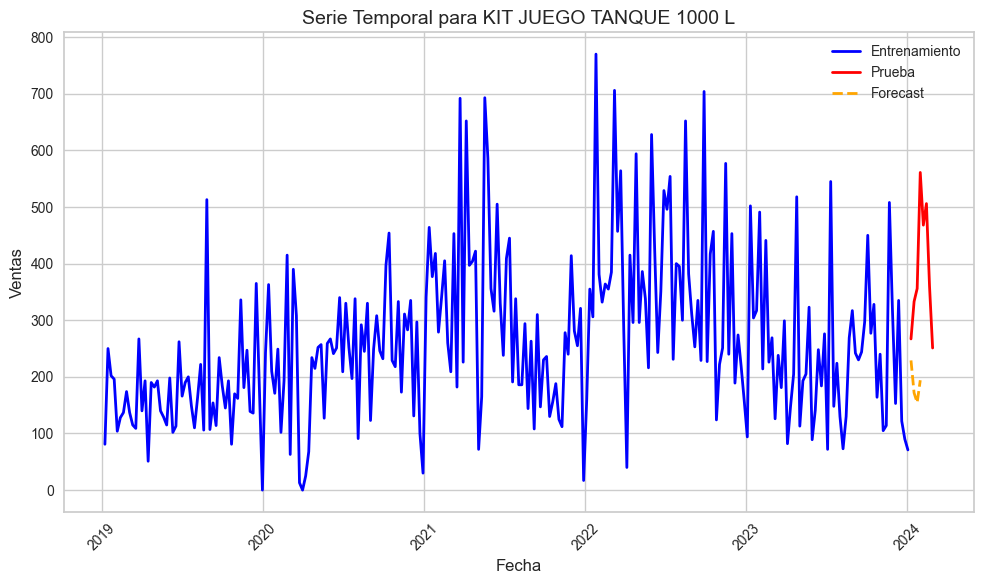

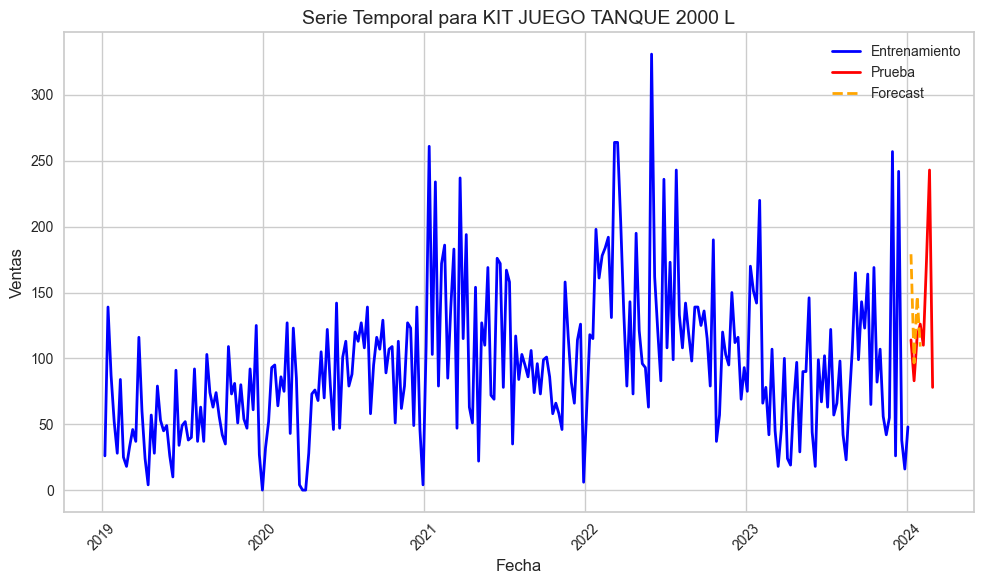

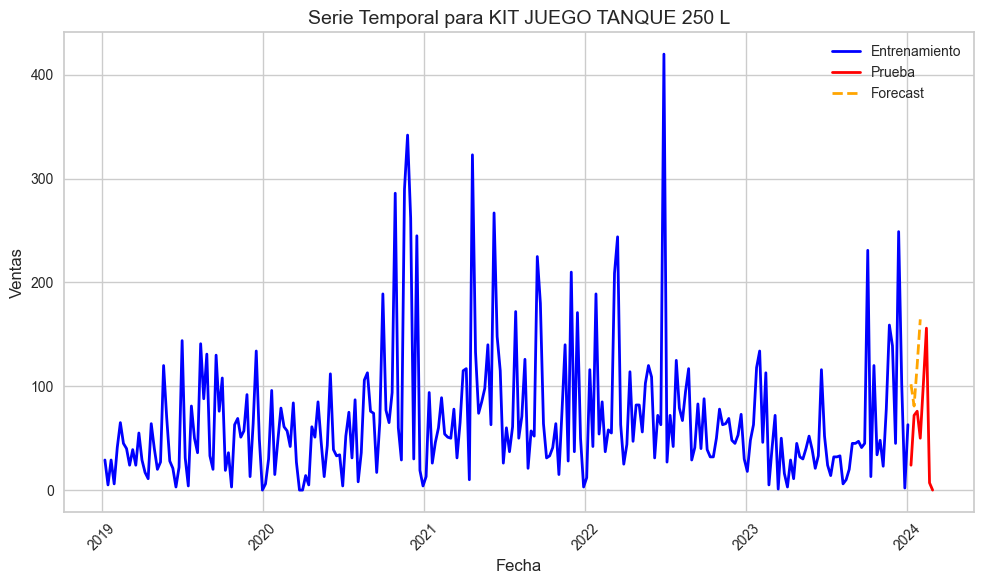

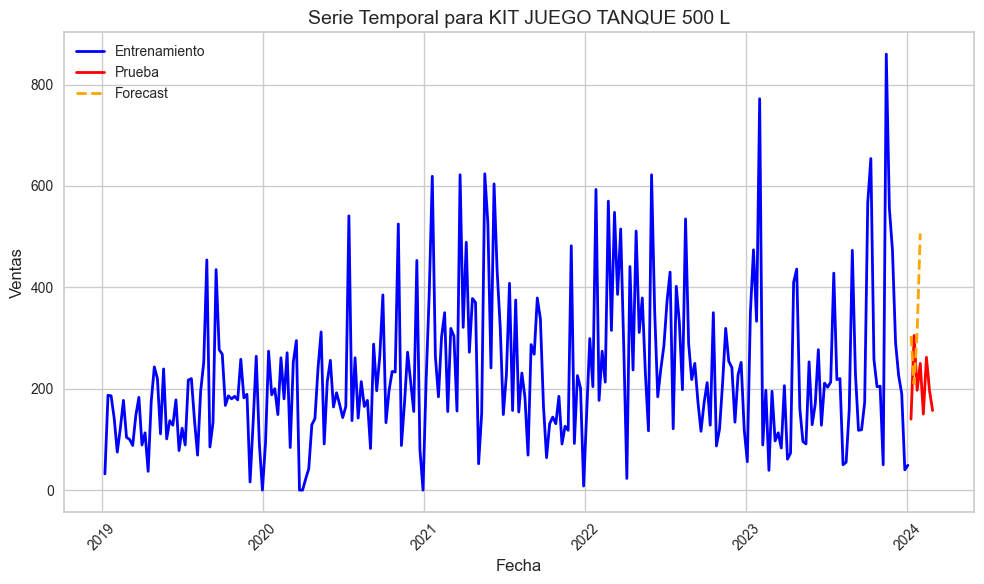

In [45]:
# Definir los colores para los diferentes conjuntos
colors = {'train': 'blue', 'test': 'red', 'forecast': 'orange'}

# Crear los gráficos para cada producto
for producto, (train_data, test_data) in train_test_dict.items():
    # Cargar el forecast desde el archivo correspondiente
    forecast_path = f"results/{producto.replace(' ', '_')}_forecast.csv"
    forecast = pd.read_csv(forecast_path, index_col=0, parse_dates=True)
    
    # Crear la figura
    plt.figure(figsize=(10, 6))

    # Graficar conjunto de entrenamiento
    plt.plot(train_data.index, train_data, label='Entrenamiento', color=colors['train'], linewidth=2)

    # Graficar conjunto de prueba
    plt.plot(test_data.index, test_data, label='Prueba', color=colors['test'], linewidth=2)

    # Graficar el forecast
    plt.plot(forecast.index, forecast.iloc[:, 0], label='Forecast', linestyle='--', color=colors['forecast'], linewidth=2)

    # Agregar título y etiquetas
    plt.title(f'Serie Temporal para {producto}', fontsize=14)
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Ventas', fontsize=12)

    # Añadir leyenda
    plt.legend()

    # Mostrar gráfico
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()